In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

%matplotlib inline

plt.rcParams.update({'font.size': 20})

# start/stop maps compare via linear residuals

In [3]:
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21/func_0/'
analysis_directory = os.path.join(root_directory, '20200115_analysis')

In [5]:
start_file = os.path.join(analysis_directory, 'start_trigger_10pc_reconstr.nii')
stop_file = os.path.join(analysis_directory, 'stop_trigger_10pc_reconstr.nii')
start_brain = bbb.load_numpy_brain(start_file)
stop_brain = bbb.load_numpy_brain(stop_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 27.02 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 35.62 ms


In [12]:
from sklearn import linear_model

In [20]:
x = start_brain.flatten().reshape(-1,1)
y = stop_brain.flatten().reshape(-1,1)

In [34]:
linear_fit = linear_model.LinearRegression().fit(x,y)
prediction = linear_fit.predict(x)
residuals = prediction - y
out = residuals.reshape(start_brain.shape)

In [38]:
to_save = ants.from_numpy(out)
file = os.path.join(analysis_directory,'start_stop_residuals.nii')
ants.image_write(to_save,file)

# try different baselines

#### Reconstruct from PCs

In [53]:
t0 = time.time()
save_file = os.path.join(root_directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(root_directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
pca_spatial.shape = (pca_spatial.shape[0], -1)
pca_spatial.shape = (pca_spatial.shape[0], 128, 79, 53)

num_pcs = 100
data = np.tensordot(pca_loadings[:,:num_pcs], pca_spatial[:num_pcs,:,:,:],axes=1)
data = np.moveaxis(data,0,-1)

print('Duration: {}'.format(time.time()-t0))

Duration: 37.128570795059204


#### Load and process fictrac

In [4]:
timestamps = bbb.load_timestamps(os.path.join(root_directory, 'imaging'))
fictrac_raw = bbb.load_fictrac(os.path.join(root_directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 1.48 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 2.94 sec


In [5]:
resolution = 10 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
behaviors = ['dRotLabY', 'dRotLabZ']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    fictrac[short] = bbb.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
xnew = np.arange(0,expt_len,resolution)

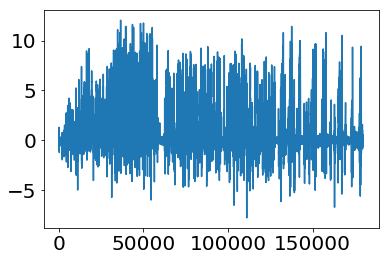

In [6]:
plt.plot(fictrac['Y'])

In [148]:
###### CURRENT BEST METHOD ######

behavior = 'Y'

B_THRESHOLD = np.std(fictrac[behavior])/4
ALIVE_TIME = 1000 # in ms
DEAD_TIME = 1000 # in ms

state = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac[behavior])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac[behavior][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if state == 'quiescent':
        if up_streak >= ALIVE_TIME:
            state = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif state == 'moving':
        if down_streak >= DEAD_TIME:
            state = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

Found 144 bouts


Text(0.5, 0, 'sec')

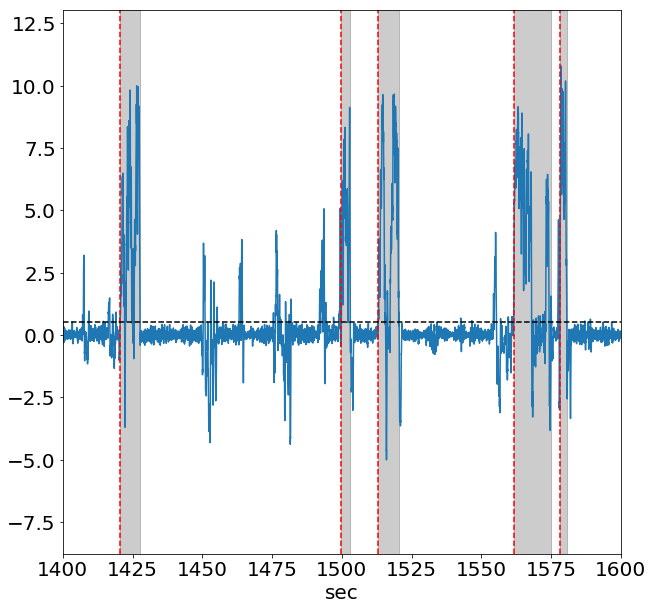

In [149]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac['Y'])
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in BOUTS:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1400,1600)
plt.xlabel('sec')
#plt.xlim(808,1000)

In [150]:
# remove bouts that have behavior too close before them
before = 3000 # in ms

before = int(before/10)
bouts=[bout for bout in BOUTS if np.mean(np.abs(fictrac['Y'][bout['start']-before:bout['start']])) < .2]
print('Remaining bouts: {}'.format(np.shape(bouts)[0]))

Remaining bouts: 47


Text(0.5, 0, 'ms')

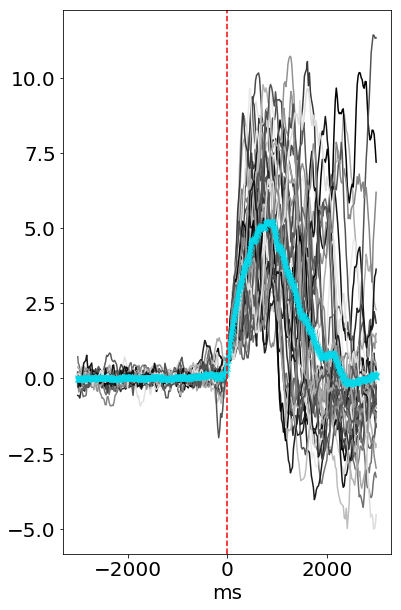

In [151]:
before = 3000 #in ms
after = 3000 # in ms

before = int(before/10) # now everything is in units of 10ms
after = int(after/10)
bins = bbb.create_bins(10,before*10,after*10)[:-1]

plt.figure(figsize=(20,10))
x=bins
plt.subplot(131)
for i,bout in enumerate(bouts):
    y=fictrac['Y'][bout['start']-before:bout['start']+after]
    try:
        plt.plot(x,y,color=str(np.random.uniform()))
    except:
        print('{} Failed'.format(i))
all_bouts = [fictrac['Y'][bout['start']-before:bout['start']+after] for bout in bouts][1:-1]
all_bouts = np.asarray(all_bouts)
avg_bout = np.mean(all_bouts,axis=0)
plt.plot(x,avg_bout,color='xkcd:aqua blue',linewidth=4,marker='x')
plt.axvline(0,linestyle='--',color='r')
plt.xlabel('ms')

#### Lets get walking and quiescent times

In [78]:
slice_num = 0
print(slice_num)
xnew = np.arange(0,expt_len,100) #first trying 100ms instead of 10ms for memory
out = interp1d(timestamps[:,slice_num], data[:,:,slice_num,:], axis=-1, bounds_error = False)
slice_test = out(xnew) #now, brain data is in 100ms steps

0


In [79]:
slice_test.shape

(128, 79, 18000)

In [152]:
slice_values = []
trigger = 'start'
for slice_num in range(data.shape[2]):
    print(slice_num)
    xnew = np.arange(0,expt_len,100) #first trying 100ms instead of 10ms for memory
    out = interp1d(timestamps[:,slice_num], data[:,:,slice_num,:], axis=-1, bounds_error = False)
    slice_test = out(xnew) #now, brain data is in 100ms steps

    before = 20 #in (10?) ms
    after = 20 # in (10?) ms
    bout_triggered_slice = [slice_test[:,:,
                                       int((bout[trigger]-before)/10): \
                                       int((bout[trigger]+after)/10)] for bout in bouts][1:-1]

    # quick and dirty scalarization
    temp = np.asarray(bout_triggered_slice)
    before_avg = np.mean(temp[:,:,:,:2],axis=-1)
    after_avg = np.mean(temp[:,:,:,2:],axis=-1)
    out = before_avg - after_avg
    slice_values.append(np.mean(out,axis=0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


KeyboardInterrupt: 

In [85]:
slice_values = np.asarray(slice_values)
slice_values_to_save = np.moveaxis(slice_values,0,-1)
slice_values_to_save = ants.from_numpy(slice_values_to_save)
file = os.path.join(analysis_directory,'20200130_start_100pc_200mswindow.nii')
ants.image_write(slice_values_to_save,file)

In [82]:
root_directory

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21/func_0/'

# Try plotting all waveforms

In [153]:
slice_values = []
trigger = 'start'
slice_num = 27
print(slice_num)
xnew = np.arange(0,expt_len,100) #first trying 100ms instead of 10ms for memory
out = interp1d(timestamps[:,slice_num], data[:,:,slice_num,:], axis=-1, bounds_error = False)
slice_test = out(xnew) #now, brain data is in 100ms steps

before = 200 #in (10?) ms
after = 200 # in (10?) ms
bout_triggered_slice = [slice_test[:,:,
                                   int((bout[trigger]-before)/10): \
                                   int((bout[trigger]+after)/10)] for bout in bouts][1:-1]

# quick and dirty scalarization
temp = np.asarray(bout_triggered_slice)

27


In [154]:
traces = np.mean(temp,axis=0)
traces = traces.reshape(-1,40)

In [155]:
traces.shape

(10112, 40)

In [107]:
traces_norm = traces - traces[:,0].reshape(-1,1)

In [108]:
traces_norm.shape

(10112, 40)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

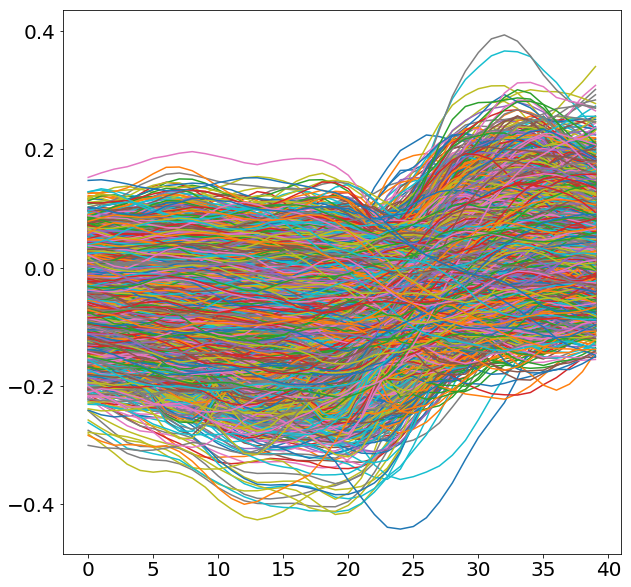

In [156]:
plt.figure(figsize=(10,10))
plt.plot(traces.T);

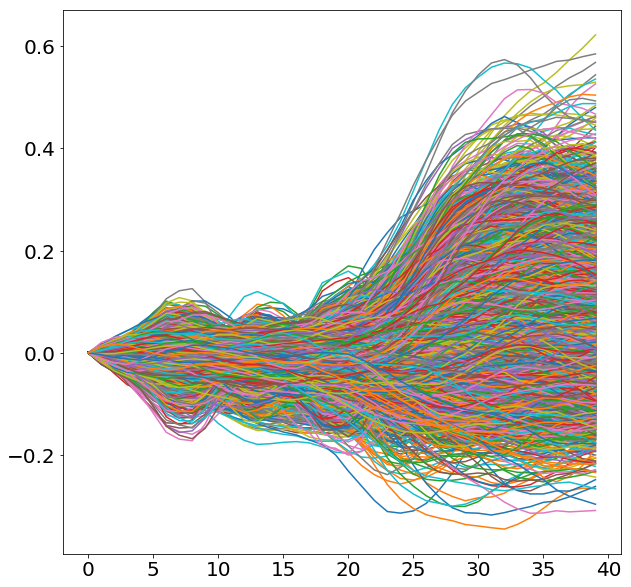

In [109]:
plt.figure(figsize=(10,10))
plt.plot(traces_norm.T);

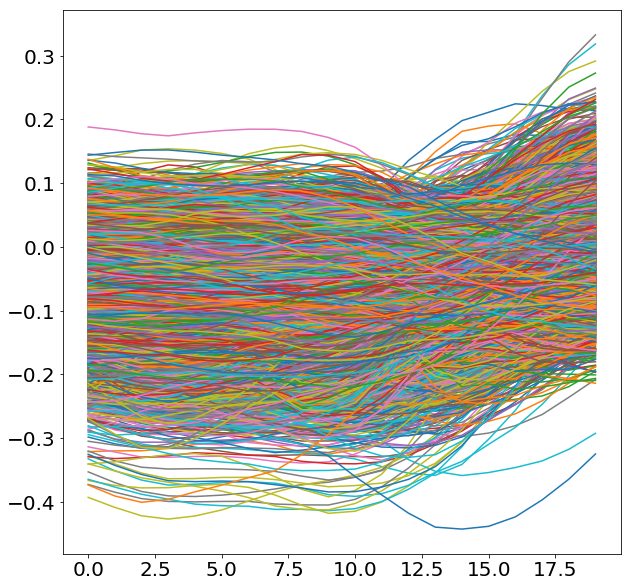

In [95]:
plt.figure(figsize=(10,10))
plt.plot(traces.T);

# retune bout finder to extract quiescent times well for baseline subtraction

Found 249 bouts


Text(0.5, 0, 'sec')

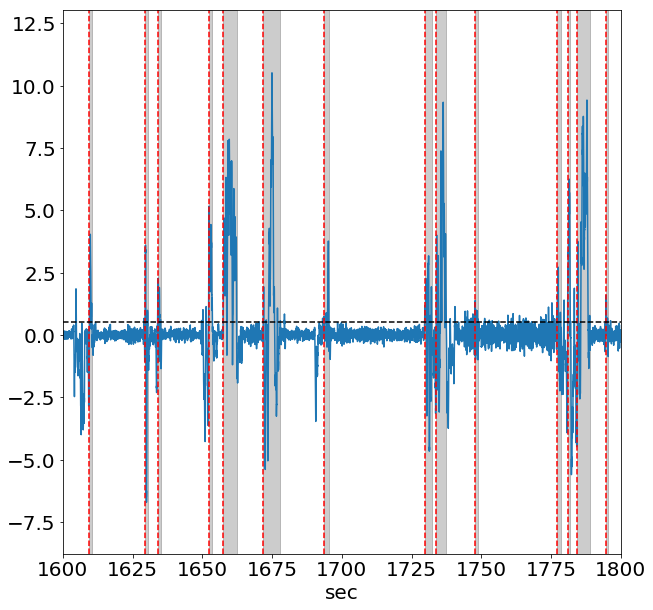

In [18]:
###### CURRENT BEST METHOD ######

behavior = 'Y'

B_THRESHOLD = np.std(fictrac[behavior])/4
ALIVE_TIME = 200 # in ms
DEAD_TIME = 1000 # in ms

state = 'quiescent'
up_streak = 0
down_streak = 0
BOUTS = []
ALIVE_TIME = int(ALIVE_TIME/resolution)
DEAD_TIME = int(DEAD_TIME/resolution)

for i in range(len(fictrac[behavior])):
    # If high behavior, reset down_streak, and add 1 to up_streak
    if fictrac[behavior][i] > B_THRESHOLD:
        down_streak = 0
        up_streak += 1
    else:
        up_streak = 0
        down_streak += 1
        
    if state == 'quiescent':
        if up_streak >= ALIVE_TIME:
            state = 'moving'
            BOUTS.append({'start': i-ALIVE_TIME})
    elif state == 'moving':
        if down_streak >= DEAD_TIME:
            state = 'quiescent'
            BOUTS[-1]['end'] = i-DEAD_TIME
print('Found {} bouts'.format(len(BOUTS)))

plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac['Y'])
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in BOUTS:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(1600,1800)
plt.xlabel('sec')
#plt.xlim(808,1000)

In [21]:
# convert from walking bouts to quiescent bouts
bouts_q = []
for i in range(len(BOUTS)-1):
    start = BOUTS[i]['end']
    end = BOUTS[i+1]['start']
    bouts_q.append({'end': end, 'start': start})

In [63]:
# erode quiescent bouts
erode = 2000 # in ms. will erode this much on each end

erode = erode/resolution
bouts_q_e = []
for i in range(len(bouts_q)):
    start = bouts_q[i]['start'] + erode
    end = bouts_q[i]['end'] - erode
    if start >= end:
        continue
    bouts_q_e.append({'end': end, 'start': start})

In [49]:
durations = [(bout['end']-bout['start'])/100 for bout in bouts_q_e]

In [52]:
len(durations)

115

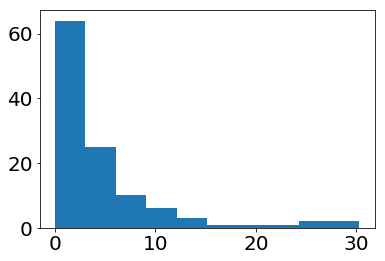

In [50]:
plt.hist(durations);

Text(0.5, 0, 'sec')

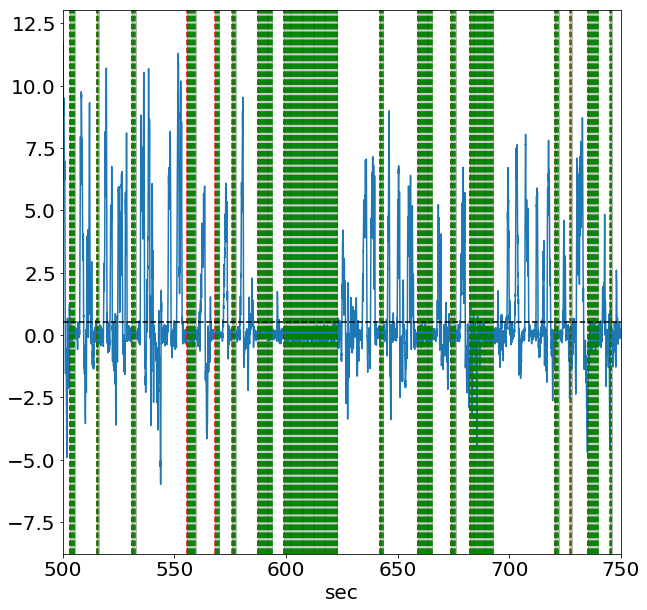

In [82]:
plt.figure(figsize=(10,10))

plt.plot(xnew/1000, fictrac['Y'])
#plt.plot(xnew/1000,PB_signal_highres/10)

for bout in bouts_q_e:
    try:
        plt.axvspan(bout['start']/100, bout['end']/100, alpha=0.2, color='k')
        plt.axvline(bout['start']/100,color='r',linestyle='--')
    except:
        pass
    
for i in indicies:
    plt.axvline(timestamps[i,z]/1000,linestyle='--',color='green')
    
plt.axhline(B_THRESHOLD,color='k',linestyle='--')
plt.xlim(500,750)
plt.xlabel('sec')
#plt.xlim(808,1000)

#### Good, have identified times of quiescence - now need to calculate average value of each voxel during these times

In [64]:
# convert to ms

bouts_q_e_ms = []
for i in range(len(bouts_q_e)):
    bouts_q_e_ms.append({'end': bouts_q_e[i]['end']*10,
                        'start': bouts_q_e[i]['start']*10})

In [88]:
# make 0/1 array matching timestamps that says if a quiescent reading

quiescent_indicies = np.zeros(timestamps.shape)

for z in range(data.shape[2]):
    indicies = []
    for index,time in enumerate(timestamps[:,z]):
        for bout in bouts_q_e_ms:
            if time > bout['start'] and time < bout['end']:
                indicies.append(index)
    quiescent_indicies[indicies,z] = 1

In [131]:
# now get a mean stationary brain signal

mean_quiescent_brain = []
for z in range(data.shape[2]):
    slice_temp=None
    normalize = len(np.where(quiescent_indicies[:,z]==1)[0])
    slice_temp = np.tensordot(data[:,:,z,:], quiescent_indicies[:,z], axes=1)/normalize
    mean_quiescent_brain.append(slice_temp)
mean_quiescent_brain = np.asarray(mean_quiescent_brain)
mean_quiescent_brain = np.moveaxis(mean_quiescent_brain,0,-1)

(128, 79, 53, 4370)